In [1]:
from sklearn.preprocessing import RobustScaler
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from helpers import *
%matplotlib inline

In [2]:
aux_columns = ['S5aux0', 'S3aux0', 'S2aux0', 'S0aux0', 'S0aux1', 'S0aux2',
       'S0aux3', 'S2aux1', 'S2aux2', 'S2aux3', 'S0aux4', 'S0aux5',
       'S0aux6', 'S0aux7', 'S0aux8']
out_columns = ['0', '1', '2']
MODEL_NAME = "XGB_apart_old"

In [3]:
vars_list_input = ['S0x0','S0x1','S0x2','S0x3','S0x4','S3x0','S3x1','S2x0','S2x1','S2x2','S2x3','S0x5','S0x6',
 'S0x7','S0x8','S0x9','S0x10','S1x0','S1x1','S1x2','S1x3','S1x4','S1x5','S5x0','S4x0','S4x1','S4x2','S3x2','S4x3',
 'S4x4','S5x1','S5x2','S5x3','S5x4','S4x5']

## XGBoost for PID Classification

In [4]:
pids = ["pion", "electron", "muon", "ghost", "proton", "kaon"]
pid_to_num = {
    name : i for i, name in enumerate(pids)
}

### Train data

In [5]:
# xgb_train_df = pd.read_csv("./data/orig_train_old.csv").drop('Unnamed: 0', axis=1)
# xgb_train = {}
# for pid in range(6):
#     train_pid = xgb_train_df[xgb_train_df.pid==pid]
#     xgb_train[pid] = train_pid[vars_list_input].values

### Test data

In [6]:
xgb_test_df = pd.read_csv('./data/orig_test_old.csv').drop('Unnamed: 0', axis=1)
aux_data = {pid: {} for pid in range(6)}
for pid in range(6):
    test_pid = xgb_test_df[xgb_test_df.pid==pid]
    aux_data[pid]['S0aux7'] = test_pid["S0aux7"].values
    aux_data[pid]['S0aux8'] = test_pid["S0aux8"].values

#### original data

In [7]:
xgb_test_df = pd.read_csv('./data/orig_test_old.csv').drop('Unnamed: 0', axis=1)
xgb_test = {}
for pid in range(6):
    test_pid = xgb_test_df[xgb_test_df.pid==pid]
    xgb_test[pid] = test_pid[vars_list_input].values

#### data after AE

In [8]:
ae_test_df = pd.read_csv('./data/ae_test_pid_{}_old.csv'.format(3)).drop('Unnamed: 0', axis=1)
ae_test = {}

for pid in range(6):
    test_pid = ae_test_df[ae_test_df.pid==pid]
    ae_test[pid] = test_pid[vars_list_input].values

#### data after AE+GAN

In [9]:
gan_test_df = pd.read_csv('./data/gan_ae_test_dim_{}_old.csv'.format(3)).drop('Unnamed: 0', axis=1)
gan_test = {}
for pid in range(6):
    test_pid = gan_test_df[gan_test_df.pid==pid]
    gan_test[pid] = test_pid[vars_list_input].values

In [10]:
# clf_name = "XGBoost_old_pids_{}-{}".format(pid_to_num['kaon'], pid_to_num['pion'])
# clf = xgb.XGBClassifier(nthread=-1, seed=111)
# clf = joblib.load(os.path.join('xgboost', clf_name) + ".pkl")

-------------

Train all the xgboost models

In [11]:
# for pid1 in range(6):
#     for pid2 in range(6):
#         if pid1 == pid2:
#             continue
#         X = np.concatenate([xgb_train[pid1], xgb_train[pid2]], axis=0)
#         Y = [0]*len(xgb_train[pid1]) + [1]*len(xgb_train[pid2])

#         clf_name = "LogReg_old_pids_{}-{}".format(pid1, pid2)
#         clf = LogisticRegression(random_state=111)
#         clf.fit(X, Y)
#         joblib.dump(clf, os.path.join('logreg', clf_name) + ".pkl")
# #         clf = joblib.load(os.path.join('xgboost', clf_name) + ".pkl")

In [12]:
def get_sorted_ans(clf, data, pid_pos, pid_neg, aux='S0aux7'):
    X = np.concatenate([data[pid_neg], data[pid_pos]], axis=0)
    Y = [0]*len(data[pid_neg]) + [1]*len(xgb_test[pid_pos])
    y_pred = clf.predict_proba(X)[:, 1]
    aux = np.concatenate([aux_data[pid_neg][aux], aux_data[pid_pos][aux]], axis=0)
    sorted_ans = np.array([[x, y, z] for x, (y, z) in zip(y_pred, zip(Y, aux))])
    sorted_ans = np.array(sorted(sorted_ans, key=lambda x: x[2]))
    return sorted_ans[:, 0], sorted_ans[:, 1], sorted_ans[:, 2]

In [13]:
def tpr_fpr(y_true, y_pred):
    tp = np.sum(y_true*y_pred)
    fn = np.sum((1-y_pred)*y_true)
    tn = np.sum((1-y_pred)*(1-y_true))
    fp = np.sum((1-y_true)*y_pred)
    
    return tp/(tp+fn), fp/(fp+tn)

def get_plot_data(pred, true, aux, thres=0.5, true_label=1, bins=20):
    pred = np.array([0 if x < thres else 1 for x in pred])
    true = np.array([1 if x == true_label else 0 for x in true])
    
    
    tprs, fprs = [], []
    
    step = (np.max(aux) - np.min(aux))/bins
    indices = [0]
    aux_index = 0
    for n_step in range(1, bins+1):
        while aux_index < len(aux) and aux[aux_index] < np.min(aux)+step*n_step:
            aux_index += 1
        indices.append(aux_index)
    
    for i in range(1, len(indices)):
        tpr, fpr = tpr_fpr(true[indices[i-1]:indices[i]], pred[indices[i-1]:indices[i]])
        tprs.append(tpr)
        fprs.append(fpr)
        
    return [(aux[min(indices[i], len(aux)-1)] + aux[indices[i-1]])/2 for i in range(1, bins+1)], tprs, fprs

def plot(x, ys, legends, aux='S0aux7', title='', alpha=0.5):
    plt.figure(figsize=(10, 6))
    
    for y, label in zip(ys, legends):
        plt.scatter(x, y, alpha=alpha, label=label)
    
    plt.ylim(-0.2, 1.2)
    plt.xlabel('{} bins'.format(aux))
    plt.ylabel('Efficiency')
    plt.legend(loc="upper left")
    plt.title(title)

In [14]:
def plot_efficiency(data, clf, feature_name, pid_pos, pid_neg, clf_threshold, max_feature_value, title=""):
    pred, true, aux = get_sorted_ans(clf, data, pid_to_num[pid_pos], pid_to_num[pid_neg], aux=feature_name)

    last_index = -1
    for i in range(len(aux)):
        if aux[i] >= max_feature_value:
            last_index = i
            break
    
    x, tpr, fpr = get_plot_data(pred[:last_index], true[:last_index], aux[:last_index], thres=0.5)
    plot(x, [tpr, fpr], 
         legends=["{} identification efficiency, thr={}".format(pid_pos, clf_threshold), 
                  "{} misidentification rate, thr={}".format(pid_neg, clf_threshold)], 
         aux=feature_name, title=title)

    plt.show()
    
def plot_hist(data, pid_pos, pid_neg, feature_name, max_feature_value, bins=20):

    aux = np.concatenate([data[pid_to_num[pid_neg]][feature_name], data[pid_to_num[pid_pos]][feature_name]], axis=0)
    
    indices = []
    for i in range(len(aux)):
        if aux[i] < max_feature_value:
            indices.append(i)
    
    plt.figure(figsize=(10, 6))
    plt.xlabel('{} value'.format(feature_name))
    plt.ylabel('num of {} values per bin'.format(feature_name))
    plt.hist(aux[indices], bins=bins, histtype='step')
    plt.title('{} values histogram'.format(feature_name))
    plt.show()
    
def plot_roc_pr(datas, clf, feature_name, pid_pos, pid_neg, clf_threshold, max_feature_value):
    for data_descr in datas:
        y_proba, y_bin, aux = get_sorted_ans(clf, datas[data_descr], pid_to_num[pid_pos], pid_to_num[pid_neg], aux=feature_name)
    
        y_pred = [1 if x > 0.5 else 0 for x in y_proba]

        encoding_dim = data_descr
        metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"], _ = \
                roc_curve(y_bin.ravel(), y_proba.ravel())
        metrics_dict['precision'][encoding_dim]["micro"], metrics_dict['recall'][encoding_dim]["micro"], _ = \
            precision_recall_curve(y_bin.ravel(), y_proba.ravel())

        metrics_dict['roc_auc'][encoding_dim]["micro"] = auc(
            metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"])
        metrics_dict['pr_auc'][encoding_dim]["micro"] = average_precision_score(y_bin.ravel(), y_proba.ravel())

        metrics_dict['f_measure'][encoding_dim] = f1_score(y_bin, y_pred, average='micro')
        metrics_dict['acc'][encoding_dim] = accuracy_score(y_bin, y_pred)

        # Plot
        display.clear_output(wait=True)
        plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02))

In [15]:
pid_neg = 'pion'
pid_pos = 'proton'
feature_name = 'S0aux7'
clf_threshold = 0.5
max_feature_value = 46885  

In [16]:
# Parameters
pid_pos = "proton"
pid_neg = "kaon"


In [17]:
metrics_dict = {
    # ROC
    'fpr': defaultdict(dict),
    'tpr': defaultdict(dict),
    'roc_auc': defaultdict(dict),

    # PR
    'precision': defaultdict(dict), 
    'recall': defaultdict(dict),
    'pr_auc': defaultdict(dict),

    'f_measure': {},
    'acc': {}
}

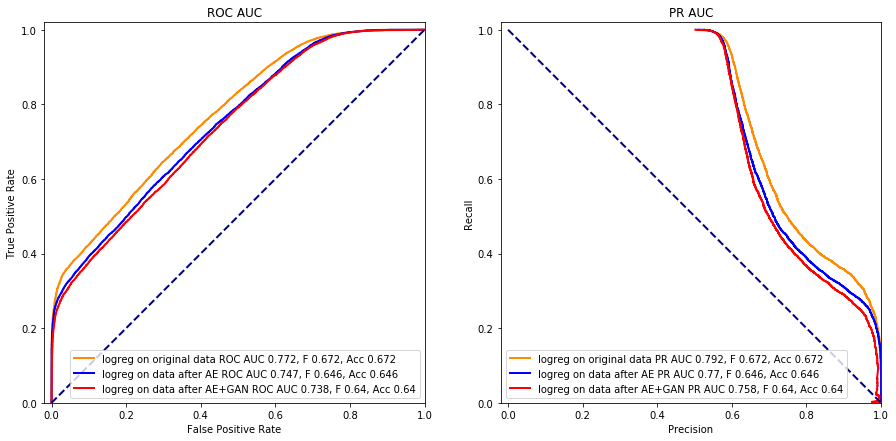

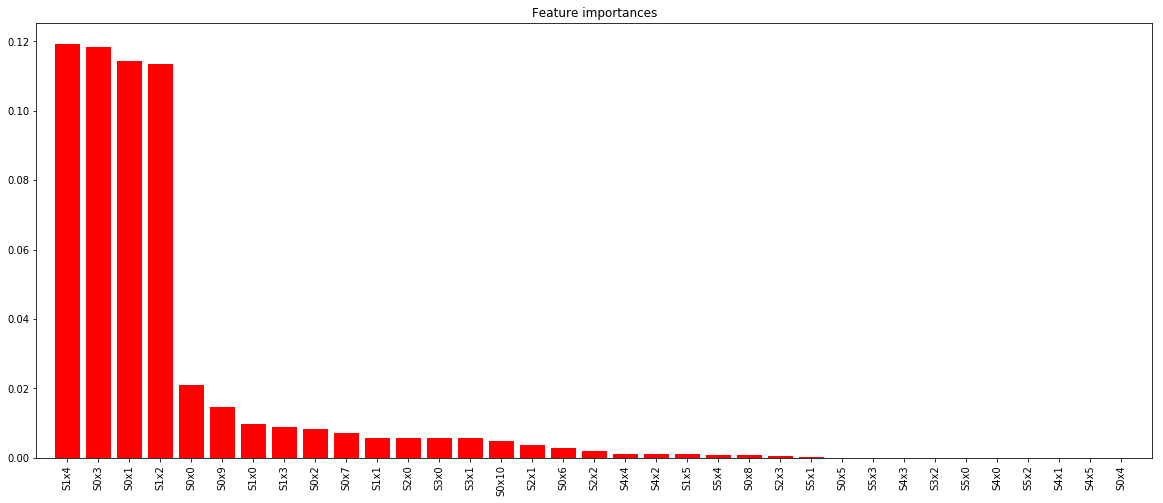

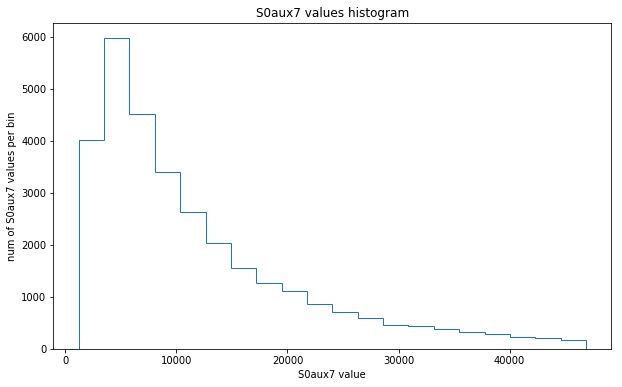

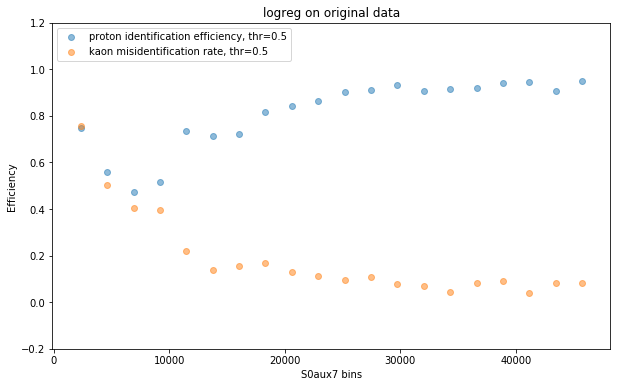

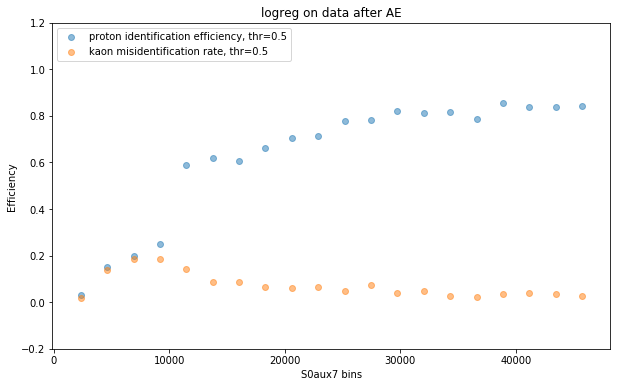

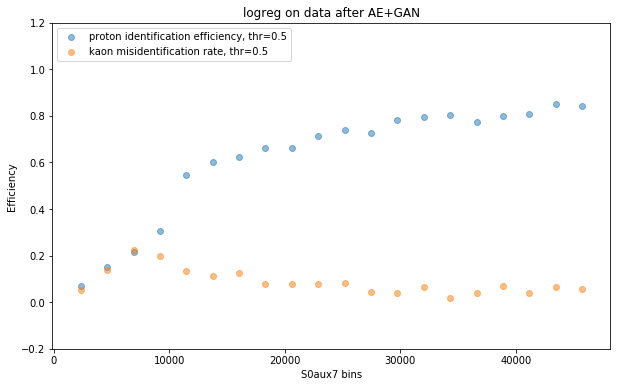

In [18]:
clf_name = "LogReg_old_pids_{}-{}".format(pid_to_num[pid_neg], pid_to_num[pid_pos])
clf = joblib.load(os.path.join('logreg', clf_name) + ".pkl")
 
datas = {
    "logreg on original data": xgb_test,
    "logreg on data after AE": ae_test,
    "logreg on data after AE+GAN": gan_test
}

plot_roc_pr(datas, clf, feature_name, pid_pos, pid_neg, 
                clf_threshold, max_feature_value)

importances = np.abs(clf.coef_[0])
indices = np.argsort(importances)[::-1]

columns_num = gan_test[0].shape[1]

plt.figure(figsize=(20, 8))
plt.title("Feature importances")
plt.bar(range(columns_num), importances[indices],
       color="r",  align="center")
plt.xticks(range(columns_num), xgb_test_df.columns[indices])
plt.xlim([-1, columns_num])
plt.xticks(rotation=90)
plt.show()

plot_hist(aux_data, pid_pos, pid_neg, feature_name, max_feature_value)

for data_descr in datas:
    plot_efficiency(datas[data_descr], clf, feature_name, pid_pos, pid_neg, 
                    clf_threshold, max_feature_value, title=data_descr)